# Introduction to Social Data Science
Authors:

Simon Guldager

Astrid Waltenburg

Amelia Asp

Agnete Pade


In [1]:
import pandas as pd 
import numpy as np 
from numpy import linalg as la
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import os 

from scipy.stats import norm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
figpath = r"/Users/bruger/Desktop/Exam/Figures"
datapath = r"/Users/bruger/Desktop/Exam/Data"

This code relies on code from exam by Abrahamsen et. al (2022) for the course Advanced Microeconometrics 2022. 

## Read and prep data 

In [3]:
filename = "data_final (1).csv"

# Combine the path and filename to create the complete file path
full_filepath = f"{datapath}/{filename}"

# Read the CSV file into a pandas DataFrame
dat = pd.read_csv(full_filepath)

In [4]:
# Drop observsations where price and rating is NaN
dat = dat.dropna(subset=['price','rating'])
# Rename danish names
dat.rename(columns={'omtaler': 'reviews', 'gæster': 'guests', 'parkering and faciliteter': 'parking','Affordability': 'affordability','Climate':'climate','Location':'location','Sights':'sights','Safety':'safety','Shopping':'shopping','soveværelser':'bedrooms'}, inplace=True)

In [5]:
unnamed_columns = [col for col in dat.columns if 'unnamed' in col.lower()]

# Drop the columns with "unnamed" in their names
dat.drop(columns=unnamed_columns, inplace=True)

dat.drop(columns='gæster.1',inplace=True)

dat = dat.fillna(0)

In [6]:
print(f'The data contains {dat.shape[0]} rows (aparments) and {dat.shape[1]} columns (variables).')

The data contains 15438 rows (aparments) and 43 columns (variables).


In [7]:
# Reset index and drop irrelevant columns
dat.reset_index(drop=True, inplace=True)
columns_to_drop = ['date', 'city','other'] 
dat = dat.drop(columns=columns_to_drop)

In [8]:
order = ['treat', 'price', 'guests','host','location','bathroom','dishwasher','affordability','work','kitchen','mailbox']
dat = dat[order + [col for col in dat.columns if col not in order]]

In [9]:
# Get the remaining column names as a list for the LASSO
column_list = dat.columns.tolist()

# Descriptive Analysis

In [10]:
# Print mean by treatment (Swift-conceft)
mean_by_category = dat.groupby('treat')['price'].mean()
print(mean_by_category)

treat
0    1171.678131
1    1067.914564
Name: price, dtype: float64


In [11]:
# Set y and X variables for descriptive analysis 
y = dat.price
X = dat.drop(["price"],axis=1)

In [12]:
# Standardize variabels
muhat = np.mean(X,axis = 0)
stdhat = np.std(X,axis = 0)
Xn = (X - muhat)/stdhat

In [13]:
# Make penalty_grid
lambda_grid = np.geomspace(10,1e3) # log-equispaced
from sklearn.linear_model import Lasso
coefs=[]
for lamb in lambda_grid:
    fit=Lasso(alpha = lamb).fit(Xn,y) # estimate
    coefs.append(fit.coef_)

In [14]:
first_sub_array = coefs[0]

In [15]:
XNames = np.array(X.columns)

In [16]:
feature_value_dict = dict(zip(XNames, first_sub_array))
feature_value_dict

feature_value_dict

# sort dict by value
sorted_x = sorted(feature_value_dict.items(), key=lambda kv: kv[1])
sorted_x

[('affordability', -226.47015961306266),
 ('work', -148.574662126943),
 ('kitchen', -94.42025277237),
 ('mailbox', -56.023129591151324),
 ('hot water', -52.76170345711102),
 ('bedrooms', -39.69375071224416),
 ('parking', -34.66396819688881),
 ('treat', -29.046306957466278),
 ('cleaning products', -16.75064744338995),
 ('smoking allowed', -12.134435853602543),
 ('safety', -10.10844949712746),
 ('security', -5.048467189362167),
 ('washing machine', -3.439729896079723),
 ('climate', -1.6830125298180938),
 ('rating', 0.0),
 ('reviews', -0.0),
 ('hangers', -0.0),
 ('wi-fi', -0.0),
 ('refrigerator', 0.0),
 ('view', -0.0),
 ('attractions nearby', -0.0),
 ('outdoor', -0.0),
 ('fireplace', -0.0),
 ('fitness equipment', 0.0),
 ('sights', 0.0),
 ('shopping', 0.0),
 ('shampoo', 10.332477695105435),
 ('hair dryer', 11.90333295806798),
 ('bed linen', 14.16612827058616),
 ('family', 14.18202012422327),
 ('entertainment', 18.726133039684488),
 ('blackout curtains', 21.592259495054805),
 ('pool etc.', 

In [17]:
color_codes = [
    '#7CCD7C',  # Light green
    '#DAA520',  # Gold
    '#7A378B',  # Purple
    '#8B0000',  # Red
    '#98F5FF',  # Bright blue
    '#000000',  # Black
    '#FF69B4',  # Pink
    '#808A87',  # Grey
    '#8B7D6B',  # Beige
    '#191970'   # Midnight blue
]

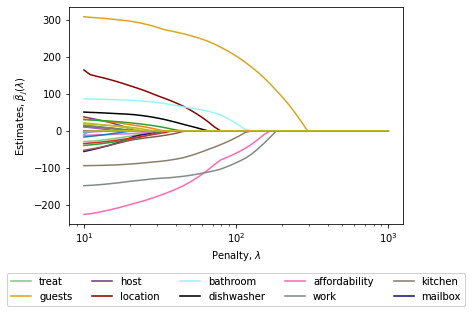

In [18]:
# Create the plot
fig, ax = plt.subplots()

# Plot the LASSO path
lines = ax.plot(lambda_grid, coefs)

# Set colors for the first ten coefficients
for i, line in enumerate(lines[:10]):
    line.set_color(color_codes[i])

ax.set_xscale('log')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')

XNames = np.array(X.columns)
lgd = ax.legend(XNames[:10], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)  # Adjust bbox_to_anchor
ax.add_artist(lgd)

# Assuming you have defined figpath
figpath = "/Users/bruger/Desktop/Exam/Figures"
filename = "lasso_path.png"

# Combine the path and filename to create the complete file path
full_figpath = f"{figpath}/{filename}"

# Save the figure as a PNG image with specified DPI
fig.savefig(full_figpath, bbox_inches='tight', dpi=300)

plt.show()

# Simple OLS

In [19]:
column_list.remove('price') # dependent variable
column_list.remove('treat') # treatment variable (Swift-concert)

In [20]:
zs = column_list
ds = ['treat']
xs = ds + zs

# avoiding missings
all_vars = ['price'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
Z = dat.loc[I, zs].values
D = dat.loc[I, ds].values
y = dat.loc[I,'price'].values.reshape((-1,1)) 

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

In [21]:
# OLS: No controls
cD = np.concatenate((np.ones_like(D),D),axis = 1)

betahat = np.linalg.inv(cD.T @ cD) @ cD.T @ y
SSR_none = (y - cD@betahat).T@(y - cD@betahat)

sigma2 = (np.array(SSR_none/(cD.shape[0] - cD.shape[1])))
cov = sigma2*la.inv(cD.T@cD)
se_none = np.sqrt(cov.diagonal()).reshape(-1, 1)

OLS_none = betahat[1]

OLS_CI = OLS_none + norm.ppf(0.975)*np.array([-se_none[1].item(),se_none[1].item()])

# Adding interaction terms

In [22]:
interactions = PolynomialFeatures(interaction_only=True, include_bias = False)
Z_int = interactions.fit_transform(Z)   # Creating control variables with interaction terms
int_names = interactions.get_feature_names_out(zs)

i_idx = []      # defining list to seperate index of variables and interaction terms with variance. 
                # the looping as below is bad code, as it could be written as a one-liner

for i in range(Z_int.shape[1]):
    if np.std(Z_int[:,i]) != 0:
        i_idx.append(i)

Z_int = Z_int[:,i_idx]      # dropping interaction terms with out variance
idx_ = int_names[i_idx]     # dropping variable names of interaction terms without variance
X_int = np.concatenate((D,Z_int),axis = 1)          # Creating all variables with interaction terms

In [23]:
y = dat.loc[I, 'price'] 
X = dat.loc[I, xs].values
D = D.flatten()
len_some = len(X)
contr_some = len(xs) - 1

betahat = np.linalg.inv(X.T @ X) @ X.T @ y

SSR_some = (y - X@betahat).T@(y - X@betahat)

sigma2 = (np.array(SSR_some/(X.shape[0] - X.shape[1])))
cov = sigma2*la.inv(X.T@X)
se_some = np.sqrt(cov.diagonal()).reshape(-1, 1)

OLS_some = betahat[1]
OLS_CI = OLS_some + norm.ppf(0.975)*np.array([-se_some[1].item(),se_some[1].item()])

# Data setup

In [24]:
# Standardize variables for LASSO 
def standardize(X):
    X_mean = np.mean(X,axis=0)
    X_std = np.std(X,axis=0)
    X_stan = (X-X_mean)/X_std
    return X_stan

X_stan = standardize(X)
Z_stan = standardize(Z)
Z_int_stan = standardize(Z_int)
X_int_stan = standardize(X_int)
D_stan = standardize(D)

# Defining penalty term

In [25]:
def CV(X_tilde, y, max_iter=5000, tol=1e-5):
    fit_cv = LassoCV(cv=5, max_iter=max_iter, tol=tol).fit(X_tilde, y)
    penalty_CV = fit_cv.alpha_
    
    return penalty_CV

def BRT(X_tilde,y):
    (N,p) = X_tilde.shape
    sigma = np.std(y)
    c = 1.1
    alpha = 0.05

    penalty_BRT = (sigma * c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))

    return penalty_BRT

def BCCH(X_tilde,y):
    (N,p) = X_tilde.shape
    c = 1.1 
    alpha = 0.05
    yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / N)) ** 0.5
    lambda_pilot = c*norm.ppf(1-alpha/(2*p))*yXscale/np.sqrt(N)

    # Pilot estimates
    coef_pilot = Lasso(alpha=lambda_pilot).fit(X_tilde,y).coef_
    coef_intercept = Lasso(alpha=lambda_pilot).fit(X_tilde,y).intercept_
    pred = (coef_intercept + X_tilde@coef_pilot)
    pred = Lasso(alpha=lambda_pilot).fit(X_tilde,y).predict(X_tilde)

    # Updated penalty
    res = y - pred
    assert res.ndim == 1        # check residuals only have one dimension
    resXscale = (np.max((X_tilde.T ** 2) @ (res ** 2) / N)) ** 0.5
    lambda_bcch = c*norm.ppf(1-alpha/(2*p))*resXscale/np.sqrt(N)

    return lambda_bcch

# Post Double Lasso

In [26]:
penalty_yx = CV(X_stan, y, max_iter=100000000) 
penalty_BRTyx = BRT(X_stan,y)
penalty_BCCHyx = BCCH(X_stan,y)
penalty_yx_1 = CV(X_int_stan, y, max_iter=100000000)  
penalty_BRTyx_1 = BRT(X_int_stan,y)
penalty_BCCHyx_1 = BCCH(X_int_stan,y)

In [27]:
# Calculating penalty terms for Swift-dummy
penalty_dz = CV(Z_stan,D,max_iter=100000000)
penalty_BRTdz = BRT(Z_stan,D)
penalty_BCCHdz = BCCH(Z_stan,D)
penalty_dz_1 = CV(Z_int_stan,D,max_iter=10000000)
penalty_BRTdz_1 = BRT(Z_int_stan,D)
penalty_BCCHdz_1 = BCCH(Z_int_stan,D)

In [28]:
fit_dz = Lasso(alpha=penalty_dz).fit(Z_stan,D) 
fit_dz_1 = Lasso(alpha=penalty_dz_1).fit(Z_int_stan,D) 

# Save residuals
resdz = D - fit_dz.predict(Z_stan)
resdz_1 = D - fit_dz_1.predict(Z_int_stan)

# Lasso on price
fit_yx = Lasso(alpha=penalty_yx).fit(X_stan,y) 
fit_yx_1 = Lasso(alpha=penalty_yx_1).fit(X_int_stan,y) 

# Lasso coefficients
coefs = fit_yx.coef_
coefs_1 = fit_yx_1.coef_

# save residuals
resyxz = y-fit_yx.predict(X_stan) + D_stan*coefs[0]
resyxz_1 = y-fit_yx_1.predict(X_int_stan) + D_stan*coefs_1[0]

/Users/bruger/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e+02, tolerance: 3.834e-01
  model = cd_fast.enet_coordinate_descent(


In [29]:
# Lasso on Taylor Dummy
fit_BRTdz = Lasso(alpha=penalty_BRTdz).fit(Z_stan,D) 
fit_BCCHdz = Lasso(alpha=penalty_BCCHdz).fit(Z_stan,D)
fit_BRTdz_1 = Lasso(alpha=penalty_BRTdz_1).fit(Z_int_stan,D) 
fit_BCCHdz_1 = Lasso(alpha=penalty_BCCHdz_1).fit(Z_int_stan,D)

# Save residuals
resdz_BRT = D - fit_BRTdz.predict(Z_stan)
resdz_BCCH = D - fit_BCCHdz.predict(Z_stan)
resdz_BRT_1 = D - fit_BRTdz_1.predict(Z_int_stan)
resdz_BCCH_1 = D - fit_BCCHdz_1.predict(Z_int_stan)

# Lasso on price
fit_BRTyx = Lasso(alpha=penalty_BRTyx).fit(X_stan,y) 
fit_BCCHyx = Lasso(alpha=penalty_BCCHyx).fit(X_stan,y) 
fit_BRTyx_1 = Lasso(alpha=penalty_BRTyx_1).fit(X_int_stan,y) 
fit_BCCHyx_1 = Lasso(alpha=penalty_BCCHyx_1).fit(X_int_stan,y) 

# Lasso coefficients
coefs_BRT = fit_BRTyx.coef_
coefs_BCCH = fit_BCCHyx.coef_
coefs_BRT_1 = fit_BRTyx_1.coef_
coefs_BCCH_1 = fit_BCCHyx_1.coef_

# save residuals
resyxz_BRT = y-fit_BRTyx.predict(X_stan) + D_stan*coefs_BRT[0]
resyxz_BCCH = y-fit_BCCHyx.predict(X_stan) + D_stan*coefs_BCCH[0]
resyxz_BRT_1 = y-fit_BRTyx_1.predict(X_int_stan) + D_stan*coefs_BRT_1[0]
resyxz_BCCH_1 = y-fit_BCCHyx_1.predict(X_int_stan) + D_stan*coefs_BCCH_1[0]

In [30]:
def PDL_ols(resdz,resyxz,d):
    denom = np.sum(resdz*d)
    num = np.sum(resdz*resyxz)
    return num/denom

def PDL_CI(resdz,resyzz):
    # Variance

    N = resyzz.shape[0]
    num = np.sum(resdz**2*resyzz**2)/N
    denom = (np.sum(resdz**2)/N)**2
    sigma2_PDL = num/denom

    # Confidence interval
    q=norm.ppf(1-0.025)
    se_PDL = np.sqrt(sigma2_PDL/N)      # calculating standard error as the squareroot of the mean variance
    CI_PDL=(((PDL-q*se_PDL).round(2),(PDL+q*se_PDL).round(2)))

    return se_PDL, CI_PDL

# Save residuals
resyzz = y - fit_yx.predict(X_stan)
resyzz_BRT = y - fit_BRTyx.predict(X_stan)
resyzz_BCCH = y - fit_BCCHyx.predict(X_stan)
resyzz_1 = y - fit_yx_1.predict(X_int_stan)
resyzz_BRT_1 = y - fit_BRTyx_1.predict(X_int_stan)
resyzz_BCCH_1 = y - fit_BCCHyx_1.predict(X_int_stan)

# Estimating Post Double Lasso
PDL = PDL_ols(resdz,resyxz,D)
PDL_BRT = PDL_ols(resdz_BRT,resyxz_BRT,D)
PDL_BCCH = PDL_ols(resdz_BCCH, resyxz_BCCH, D)
PDL_1 = PDL_ols(resdz_1,resyxz_1,D)
PDL_BRT_1 = PDL_ols(resdz_BRT_1,resyxz_BRT_1,D)
PDL_BCCH_1 = PDL_ols(resdz_BCCH_1, resyxz_BCCH_1, D)

# estimating standard errors and confidence interval for Post Double Lasso
se_PDL, CI_PDL = PDL_CI(resdz, resyzz)
se_PDL_BRT, CI_PDL_BRT = PDL_CI(resdz_BRT, resyzz_BRT)
se_PDL_BCCH, CI_PDL_BCCH = PDL_CI(resdz_BCCH, resyzz_BCCH)
se_PDL_1, CI_PDL_1 = PDL_CI(resdz_1, resyzz_1)
se_PDL_BRT_1, CI_PDL_BRT_1 = PDL_CI(resdz_BRT_1, resyzz_BRT_1)
se_PDL_BCCH_1, CI_PDL_BCCH_1 = PDL_CI(resdz_BCCH_1, resyzz_BCCH_1)

# Results

In [31]:
# Estimates
estimates = np.array([OLS_none[0], OLS_some, PDL, PDL_1, PDL_BCCH, PDL_BCCH_1]).round(1)
label_over_column = ['(1)','(2)','(3)','(4)','(5)','(6)']
label_column = np.array(['OLS', 'OLS', 'PDL (CV)', 'PDL (CV)', 'PDL (BCCH)', 'PDL (BCCH)'])
label_row = ['' ,'Swift-effect', 'se', 'No controls','No obs','$\lambda^{dz}$','$\lambda^{yx}$','t-statistic']
se = np.array([se_none[1].item(),se_some[1].item(),se_PDL, se_PDL_1,se_PDL_BCCH, se_PDL_BCCH_1]).round(1)
no_controls = np.array([0, contr_some, len(zs), Z_int_stan.shape[1], len(zs), Z_int_stan.shape[1]])
no_obs = np.array([len(y), len(y), len(y), len(y), len(y), len(y)])

pens_dz = np.array(['','', penalty_dz.round(4), penalty_dz_1.round(4), penalty_BCCHdz.round(4),penalty_BCCHdz_1.round(4)])
pens_yx = np.array(['','', penalty_yx.round(1), penalty_yx_1.round(1), penalty_BCCHyx.round(1), penalty_BCCHyx_1.round(1)])

t_statistic = (estimates/se).round(2)    

data = np.row_stack((label_column ,estimates, se, no_controls,no_obs, pens_dz, pens_yx,t_statistic))

df = pd.DataFrame(data = data, index = label_row, columns = label_over_column)

print(df.to_latex(escape = False))

\begin{tabular}{lllllll}
\toprule
{} &     (1) &    (2) &       (3) &       (4) &         (5) &         (6) \\
\midrule
               &     OLS &    OLS &  PDL (CV) &  PDL (CV) &  PDL (BCCH) &  PDL (BCCH) \\
Swift-effect   &  -103.8 &  149.2 &    -110.2 &      83.9 &      -108.6 &       -79.6 \\
se             &    12.6 &    3.0 &      14.7 &      38.5 &        14.5 &        15.6 \\
No controls    &       0 &     38 &        38 &       741 &          38 &         741 \\
No obs         &   15438 &  15438 &     15438 &     15438 &       15438 &       15438 \\
$\lambda^{dz}$ &         &        &    0.0099 &    0.0003 &      0.0118 &      0.0153 \\
$\lambda^{yx}$ &         &        &      22.2 &      11.8 &        32.7 &        51.3 \\
t-statistic    &   -8.24 &  49.73 &      -7.5 &      2.18 &       -7.49 &        -5.1 \\
\bottomrule
\end{tabular}



/var/folders/fj/trr23jhx25j8_78nf00613400000gn/T/ipykernel_20356/105034644.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape = False))


## Table with estimates of control variables

In [32]:
# LASSO estimates - CV with out interactions
df_tab = pd.DataFrame(data = np.row_stack((fit_dz.coef_,fit_yx.coef_[1:])).T, index = zs,columns = ['dz','yx']) # collecting all estimates for both stages, exluding air bnb prices
print(df_tab.loc[~(df_tab==0).all(axis=1)].round(4).to_latex(escape=False)) # removing all estimates equal to zero

\begin{tabular}{lrr}
\toprule
{} &      dz &        yx \\
\midrule
guests            & -0.0113 &  294.2062 \\
host              &  0.0009 &    0.0000 \\
location          & -0.0000 &  116.3878 \\
bathroom          & -0.0743 &   81.8189 \\
dishwasher        &  0.0039 &   43.0714 \\
affordability     & -0.1920 & -195.0663 \\
work              & -0.0341 & -134.8818 \\
kitchen           & -0.0022 &  -88.6867 \\
mailbox           &  0.0105 &  -13.3022 \\
rating            &  0.0008 &    0.0000 \\
bedrooms          & -0.0000 &  -19.2647 \\
hair dryer        &  0.0032 &    0.0000 \\
shampoo           &  0.0012 &    0.0000 \\
hot water         &  0.0000 &  -22.7116 \\
hangers           &  0.0066 &   -0.0000 \\
entertainment     & -0.0070 &    7.6808 \\
parking           &  0.0000 &  -17.5242 \\
smoking allowed   & -0.0000 &   -6.6222 \\
blackout curtains &  0.0016 &    3.6515 \\
outdoor           & -0.0006 &   -0.0000 \\
temperature       &  0.0000 &   14.1344 \\
pool etc.         &  0.0000 & 

/var/folders/fj/trr23jhx25j8_78nf00613400000gn/T/ipykernel_20356/384918176.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_tab.loc[~(df_tab==0).all(axis=1)].round(4).to_latex(escape=False)) # removing all estimates equal to zero


In [33]:
# LASSO estimates - CV with interaction terms
df_tab_int = pd.DataFrame(data = np.row_stack((fit_dz_1.coef_,fit_yx_1.coef_[1:])).T, index = idx_,columns = ['dz','yx']) # using idx_, as this variable is control variable names, adjusted for those delted due to no variance
print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &      dz &        yx \\
\midrule
host                                 & -0.0147 &   -0.0000 \\
location                             & -0.9147 &    0.0000 \\
bathroom                             &  0.1302 &   -0.0000 \\
affordability                        & -0.2010 &   -0.0000 \\
work                                 & -0.0000 & -165.1010 \\
kitchen                              & -0.0000 &  -95.4701 \\
mailbox                              & -0.0000 &   -5.8481 \\
rating                               &  0.0170 &    0.0000 \\
reviews                              & -0.0157 &   -0.0000 \\
bedrooms                             & -0.0206 &  -46.2560 \\
hair dryer                           & -0.0110 &    0.0000 \\
shampoo                              & -0.0023 &    0.0000 \\
hot water                            & -0.0175 &   -0.0000 \\
entertainment                        & -0.0215 &    0.0000 \\
security                             & -0.0007 &  -14.4686 \\
ref

/var/folders/fj/trr23jhx25j8_78nf00613400000gn/T/ipykernel_20356/1454723399.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))


In [34]:
# LASSO estimates - BCCH without interaction terms
df_tab_int = pd.DataFrame(data = np.row_stack((fit_BCCHdz.coef_,fit_BCCHyx.coef_[1:])).T, index = zs,columns = ['dz','yx']) # using idx_, as this variable is control variable names, adjusted for those delted due to no variance
print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &      dz &        yx \\
\midrule
guests            & -0.0133 &  275.3438 \\
location          & -0.0000 &   90.3472 \\
bathroom          & -0.0709 &   74.8247 \\
dishwasher        &  0.0003 &   32.0697 \\
affordability     & -0.1903 & -172.6494 \\
work              & -0.0319 & -128.2792 \\
kitchen           & -0.0007 &  -82.1561 \\
mailbox           &  0.0071 &   -0.0000 \\
bedrooms          & -0.0000 &   -0.5163 \\
hair dryer        &  0.0002 &    0.0000 \\
shampoo           &  0.0026 &    0.0000 \\
hot water         &  0.0000 &  -13.2255 \\
hangers           &  0.0054 &   -0.0000 \\
entertainment     & -0.0054 &    0.0000 \\
parking           &  0.0000 &   -5.9054 \\
blackout curtains &  0.0014 &    0.0000 \\
temperature       &  0.0000 &    0.2804 \\
pool etc.         &  0.0000 &   10.0872 \\
sights            & -0.6297 &    0.0000 \\
shopping          &  0.9053 &    0.0000 \\
climate           &  0.0921 &   -0.0000 \\
\bottomrule
\end{tabular}



/var/folders/fj/trr23jhx25j8_78nf00613400000gn/T/ipykernel_20356/2027556558.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))


In [35]:
# LASSO estimates - BCCH with interaction terms
df_tab_int = pd.DataFrame(data = np.row_stack((fit_BCCHdz_1.coef_,fit_BCCHyx_1.coef_[1:])).T, index = idx_,columns = ['dz','yx'])
# no non-zero control variables
print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))

\begin{tabular}{lrr}
\toprule
{} &      dz &        yx \\
\midrule
work                     & -0.0000 & -128.9054 \\
kitchen                  & -0.0000 &  -58.8744 \\
shopping                 &  0.3443 &    0.0000 \\
guests bathroom          & -0.0170 &   91.9879 \\
guests dishwasher        &  0.0000 &   11.1748 \\
guests work              & -0.0000 &  212.5200 \\
guests entertainment     & -0.0036 &   13.4219 \\
host bathroom            &  0.0000 &    4.2363 \\
host shopping            &  0.0070 &    0.0000 \\
location bathroom        & -0.2036 &    0.0000 \\
location washing machine & -0.0002 &   -0.0000 \\
location sights          & -0.0000 &   36.4820 \\
location safety          & -0.0000 &   22.6582 \\
bathroom dishwasher      & -0.0000 &   18.0977 \\
bathroom rating          &  0.0225 &    0.0000 \\
bathroom reviews         & -0.0098 &   -0.0000 \\
bathroom hair dryer      &  0.0308 &    0.0000 \\
bathroom parking         &  0.0224 &    0.0000 \\
bathroom smoking allowed &  0.010

/var/folders/fj/trr23jhx25j8_78nf00613400000gn/T/ipykernel_20356/1174392149.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_tab_int.loc[~(df_tab_int==0).all(axis=1)].round(4).to_latex(escape=False))
